# 3D (x-y-t) field generation and lagrangian simulation

This example will cover:

 - Generation of a synthetic x-y-t field
 - Simulation of drifter trajectories

Prerequisite, have parcels installed, see [OceanParcels doc](https://oceanparcels.org).
If under conda environment: `conda install -c conda-forge parcels`

In [1]:
import os
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import xrft

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats

import nwastats as st
day = 86400

data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
#data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

production = False
#production = True

In [2]:
local_cluster = True

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime="03:00:00")
    #cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=15)

client = Client(cluster)
cluster

LocalCluster(1e164a14, 'tcp://127.0.0.1:58208', workers=4, threads=4, memory=16.00 GiB)

## Generate velocity fields

The different flow formulations considered are:

1. direct velocity field generation: $u$ and $v$ specified independantly and with separable autocorrelations (x/y/t).
2. streamfunction and potential field generation: $u=-\partial_y \psi + \partial_x \phi$ and $v=\partial_x \psi + \partial_y \phi$, where $\psi$ and $\phi$ are independent fields with separable autocorrelations.

**Points addressed:**

- kinetic energy spectral slopes need to match general expectation of isotropic wavenumber spectral slope between -3 and -2.
- separability implies non-isotropic spatial spectra and weird deformation (e.g. vorticity, divergence) fields, we opt for isotropic formulation

**Points to potentially in the future address:**

- $\psi$ $\phi$ correlations have been considered in the past, see mention of spirality in [Wang and Buhler 2021]
- could we make the problem 2D periodic?

**Note:** Link Matern parameters ($\nu$, n=1) to spectral slope $s$ ($k^{-s}$): $s=2\nu+n$.

In [3]:
#### 
# Input parameters

# signal characteristics
#U = .01     # amplitude m/s (will be rescale for streamfunction/potential amplitudes)
U = .1     # amplitude m/s (will be rescale for streamfunction/potential amplitudes) - reference case
#U = 1.     # amplitude m/s (will be rescale for streamfunction/potential amplitudes)
λx = 100   # km
λy = 100   # km
λt = 5     # days

# noise:
#noise = 0.01
noise = 0. # noise will be added to observations just before inference

# velocity field formulation
#kind = "uv"
kind, pp_ratio = "pp", 0.

# covariance mode
#Cmodel=("matern2_iso", "matern12")
#Cmodel=("matern32_iso", "matern12")
Cmodel=("matern52_iso", "matern12")

# Grid parameters: size, spacing
Nx, dx = 1000, 1.  # km
Ny, dy = 1000, 1.  # km
Nt, dt = 100*24, 1/24  # days
chunks = (20,-1)

### dev
Nx, dx = 100, 10.  # km
Ny, dy = 100, 10.  # km
Nt, dt = 100*2, 1/2  # days
chunks = (10,-1)

# rescale grid parameters for some models
if "iso" in Cmodel[0]:
    #factor = 10
    #factor = 5
    factor = 2
    Nx //= factor
    Ny //= factor
    dx *= factor  # km
    dy *= factor  # km

In [4]:
### velocity field formulation

if kind=="uv":
    # u-v formulation
    η = U
    amplitudes = (η, η)
    suffix = kind
elif kind=="pp":
    # psi-phi field formulation
    #λ = np.sqrt(λx**2 + λy**2)
    λ = λx    
    if "matern32" in Cmodel[0]:
        ν_space = 3/2
    elif "matern52" in Cmodel[0]:
        ν_space = 5/2
    else:
        assert False, "implement scaling factor"    
    η = np.sqrt((ν_space-1)/ν_space)*U*λ
    amplitudes = (η*(1-pp_ratio), η*pp_ratio)
    #scale = λ*0.5
    #amplitudes = (scale * amplitudes[0], scale * amplitudes[1])

if "matern12" in Cmodel[1]:
    ν_time = 1/2
else:
    assert False, "implement scaling factor"


In [5]:
# assemble prefix and parameters for storage

#suffix = "_".join([Cmodel[0], Cmodel[1],kind, f"r{pp_ratio}"])
suffix = "_".join([Cmodel[0], Cmodel[1], kind, f"r{pp_ratio}_u{U}"])
run_dir = os.path.join(data_dir, "3D_"+suffix)

params = dict(
    U = U,
    eta = η,
    lambda_x = λx,
    lambda_y = λy, 
    lambda_t = λt,
    cov_x = Cmodel[0],
    cov_y = Cmodel[0],
    cov_t = Cmodel[1],
    kind = kind,
    nu_space = ν_space,
    nu_time = ν_time,
    amplitude0 = amplitudes[0],
    amplitude1 = amplitudes[1],
    pp_ratio = pp_ratio,
    noise = noise,
    velocity_deficit = st.amplitude_decifit(dx, λx, ν_space),
)

print(run_dir)
params

data/3D_matern52_iso_matern12_pp_r0.0_u0.1


{'U': 0.1,
 'eta': 7.745966692414835,
 'lambda_x': 100,
 'lambda_y': 100,
 'lambda_t': 5,
 'cov_x': 'matern52_iso',
 'cov_y': 'matern52_iso',
 'cov_t': 'matern12',
 'kind': 'pp',
 'nu_space': 2.5,
 'nu_time': 0.5,
 'amplitude0': 7.745966692414835,
 'amplitude1': 0.0,
 'pp_ratio': 0.0,
 'noise': 0.0,
 'velocity_deficit': 0.9345640852308769}

### start assembling covariances

In [6]:
# actually generates covariances
#C, X, N, isotropy = st.generate_covariances(Cmodel, Nx, Ny, Nt, dx, dy, dt, λx, λy, λt)
#C, X, N, isotropy = st.generate_covariances(Cmodel, (Nx, Ny, Nt), (dx, dy, dt), (λx, λy, λt))
C, X, N, isotropy = st.generate_covariances(Cmodel, (Nx, Ny, Nt), (dx, dy, dt), (λx, λy, λt), xchunks=chunks)

# add jitter on diagonal of temporal autocovariance or get at cholesky: LinAlgError: Matrix is not positive definite
jitter = 1e-6
if len(C)==2:
    C = C[0], C[1]+jitter*np.eye(*C[1].shape)
elif len(C)==3:
    C = C[0], C[1], C[2]+jitter*np.eye(*C[2].shape)

Space covariance model: matern52_iso
Covariance models: time=matern12


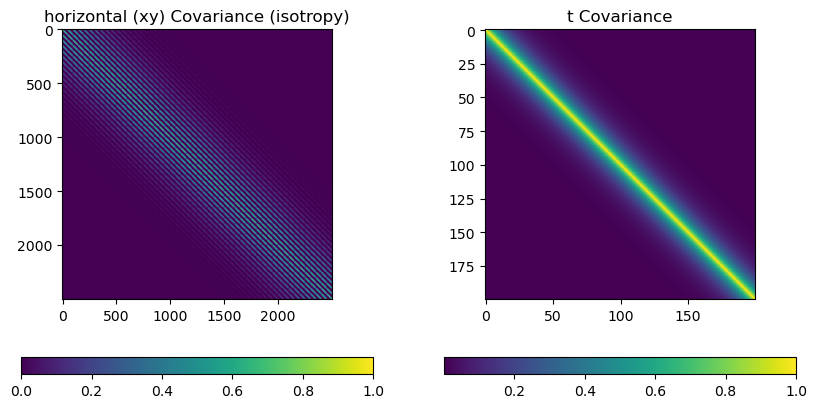

In [7]:
#plot = False
plot = True

if len(C)==3 and plt:
    
    Cov_x, Cov_y, Cov_t = C
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))

    ax = axes[0]
    h = ax.imshow(Cov_x)
    #h = ax.imshow(Cov_d)
    plt.colorbar(h, location="bottom")
    ax.set_title("x Covariance")

    ax = axes[1]
    h = ax.imshow(Cov_y)
    plt.colorbar(h, location="bottom")
    ax.set_title("y Covariance")

    ax = axes[2]
    h = ax.imshow(Cov_t)
    plt.colorbar(h, location="bottom")
    ax.set_title("t Covariance")
    
if len(C)==2 and plot:
    
    Cov_d, Cov_t = C
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    ax = axes[0]
    h = ax.imshow(Cov_d)
    #h = ax.imshow(Cov_d)
    plt.colorbar(h, location="bottom")
    ax.set_title("horizontal (xy) Covariance (isotropy)")

    ax = axes[1]
    h = ax.imshow(Cov_t)
    plt.colorbar(h, location="bottom")
    ax.set_title("t Covariance")

## flow generation

In [8]:
if production:
    ds = st.generate_uv(kind, N, C, X, amplitudes)
    ds.attrs.update(**params)
    ds = ds.chunk(dict(x=-1))

In [9]:
if production:
    ds.to_zarr(os.path.join(run_dir, "flow.zarr"), mode="w")

### reload and plot

In [10]:
ds = xr.open_zarr(os.path.join(run_dir, "flow.zarr"), decode_times=False)

In [11]:
std_time = ds.std("time").compute()
std_space = ds.std(["x", "y"]).compute()
std = ds.std().compute()

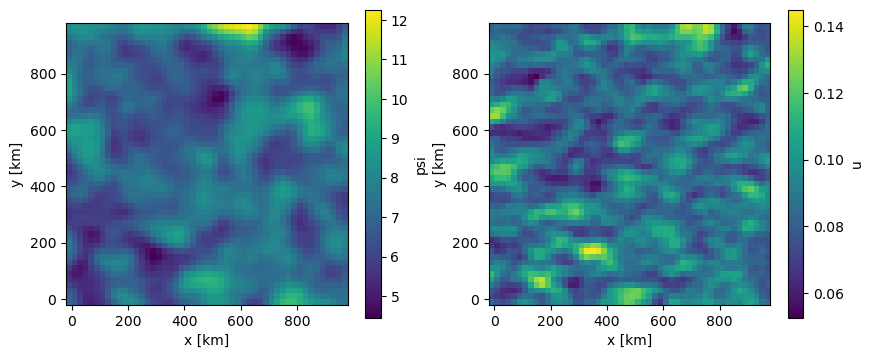

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
std_time.psi.plot(ax=axes[0])
axes[0].set_aspect("equal")
std_time.u.plot(ax=axes[1])
axes[1].set_aspect("equal")

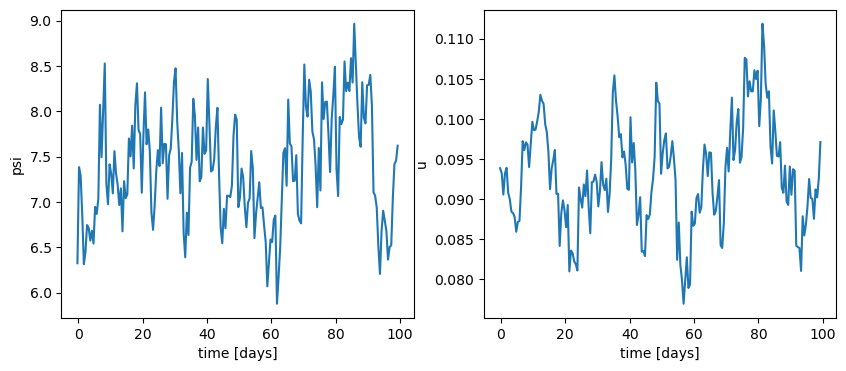

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
std_space.psi.plot(ax=axes[0])
std_space.u.plot(ax=axes[1])

In [14]:
# verifies amplitudes on full dataset: psi, phi, u, v
x, y = η*(1-pp_ratio), float(std.psi)
print(f"psi, input={x:.2f}, measured={y:.2f}, diff={(y-x)/x*100:.1f}%")
#
x, y = η*pp_ratio, float(std.phi)
print(f"phi, input={x:.2f}, measured={y:.2f}, diff={(y-x)/x*100:.1f}%")
#
x, y = U, float(std.u)
print(f"U, input={x:.3f}, measured={y:.3f}, diff={(y-x)/x*100:.1f}%")
#
x, y = U, float(std.v)
print(f"V, input={x:.3f}, measured={y:.3f}, diff={(y-x)/x*100:.1f}%")

psi, input=7.75, measured=7.55, diff=-2.5%
phi, input=0.00, measured=0.00, diff=nan%
U, input=0.100, measured=0.093, diff=-6.6%
V, input=0.100, measured=0.092, diff=-7.5%


/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_46373/1461356170.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(f"phi, input={x:.2f}, measured={y:.2f}, diff={(y-x)/x*100:.1f}%")


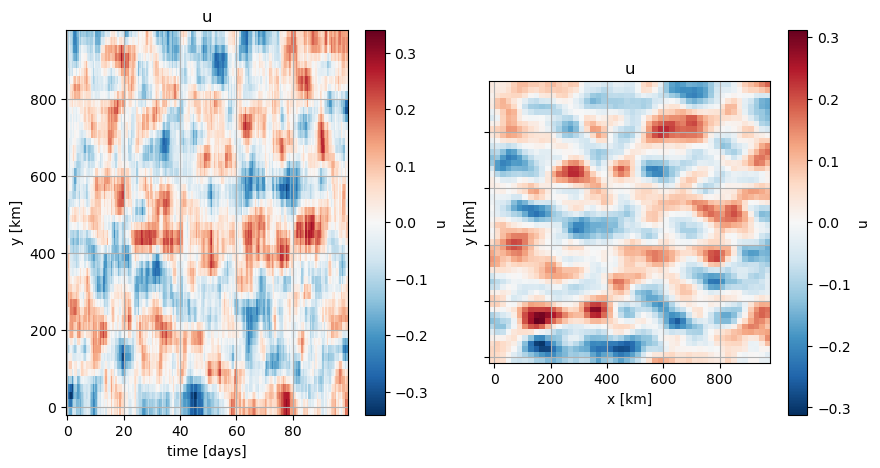

In [15]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True)

ax = axes[0]
ds.u.isel(x=ds.x.size//2).plot(ax=ax, x="time", y="y")
ax.grid()
ax.set_title("u")

ax = axes[1]
ds.u.isel(time=0).plot(ax=ax, x="x", y="y")
ax.grid()
ax.set_title("u")
ax.set_aspect("equal")

In [16]:
_ds = ds.isel(time=0)

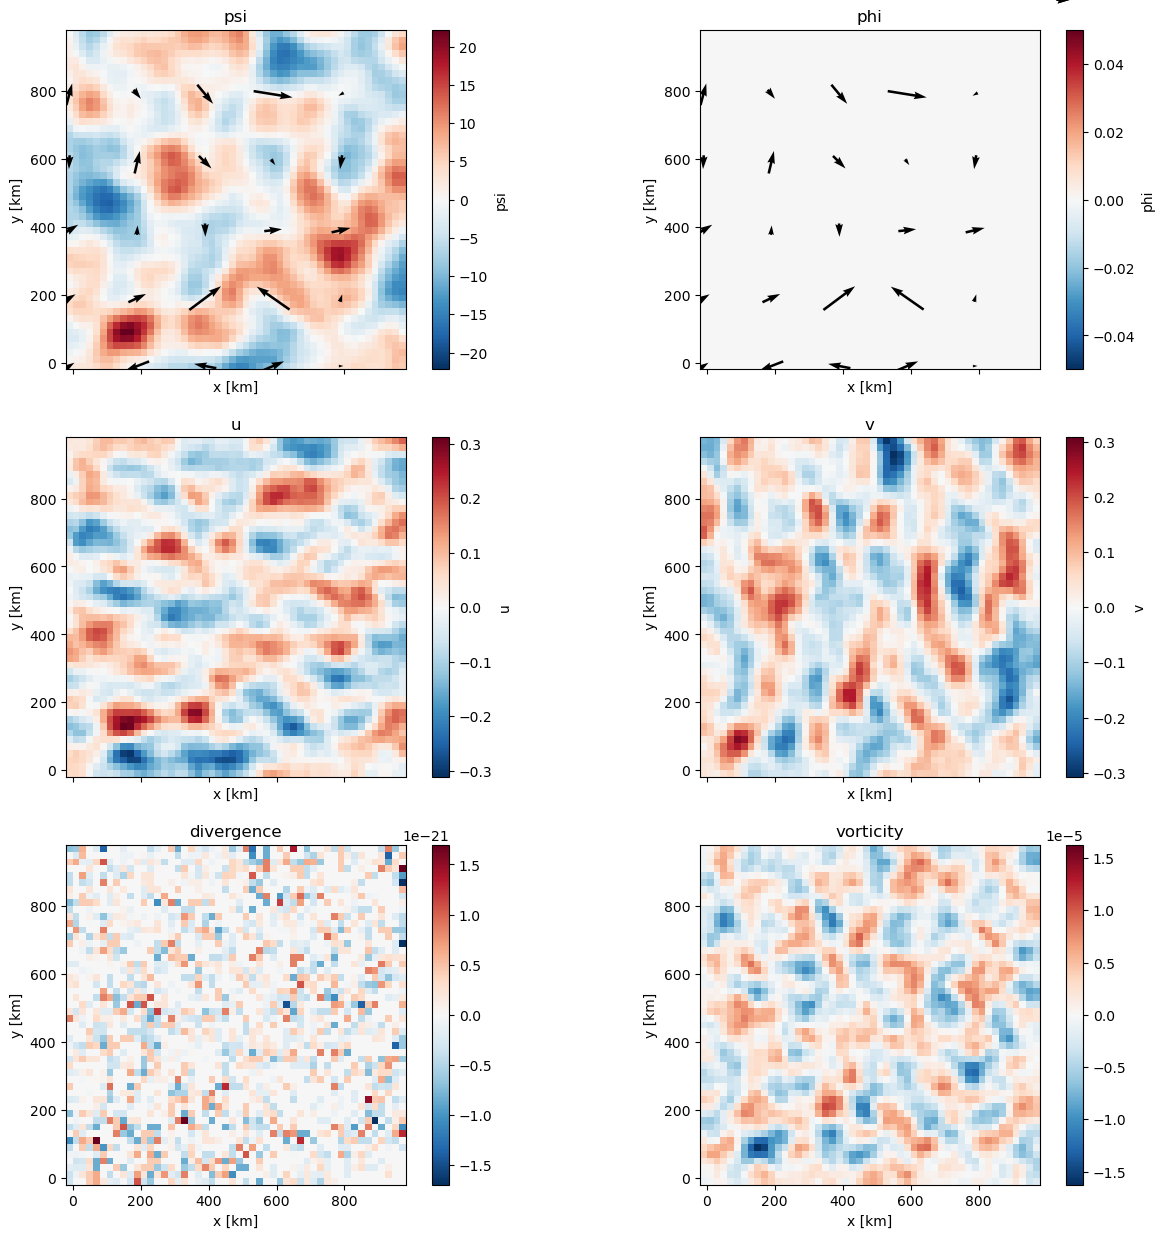

In [17]:
st.plot_snapshot(_ds, darrow=10);

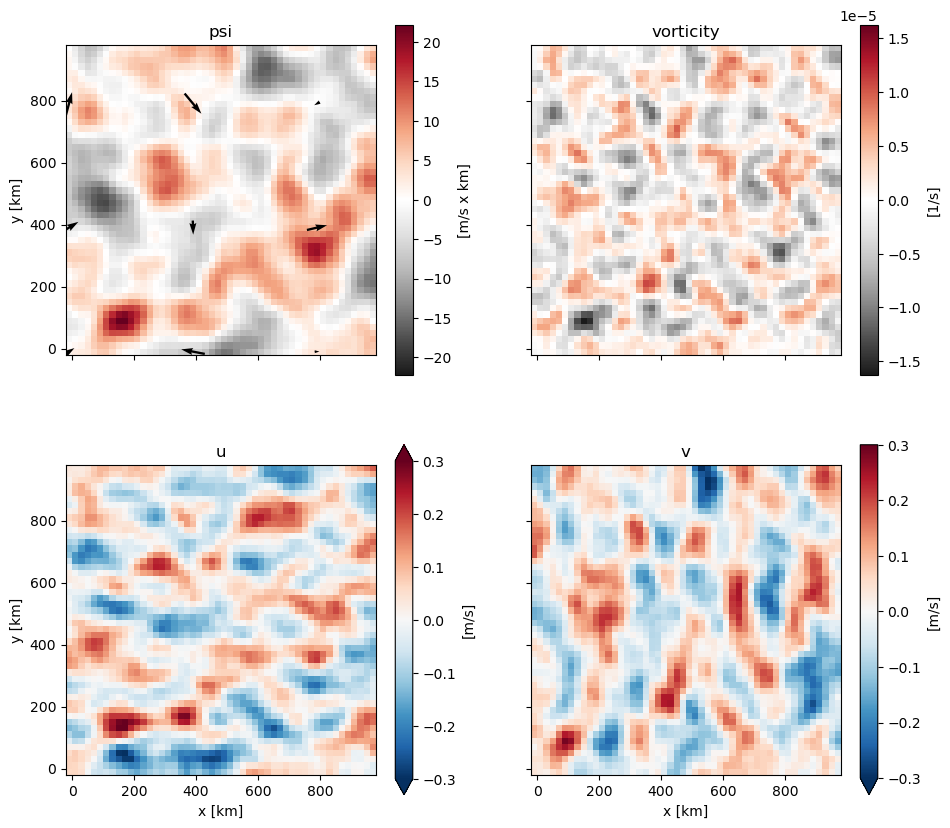

In [18]:
def plot_snapshot_vortical(ds, darrow=20):
    
    fig, axes = plt.subplots(2,2,figsize=(11,10), sharex=True, sharey=True)
    
    dsa = ds.isel(x=slice(0,None,darrow), y=slice(0,None,darrow))

    ax = axes[0, 0]
    ds.psi.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[m/s x km]"})
    dsa.plot.quiver("x", "y", "u", "v", ax=ax, add_guide = False)
    ax.set_aspect("equal")
    ax.set_title("psi")
    ax.set_xlabel("")
    
    ## velocities
    u_scale = U*3

    ax = axes[1, 0]
    ds.u.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("u")
    
    ax = axes[1, 1]
    ds.v.plot(ax=ax, cmap="RdBu_r", cbar_kwargs={'label': "[m/s]"}, vmax=u_scale)
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("v")
    ax.set_ylabel("")
    
    ##
    vorticity = ds.v.differentiate("x")/1e3 - ds.u.differentiate("y")/1e3
    
    ax = axes[0, 1]
    vorticity.plot(ax=ax, cmap="RdGy_r", cbar_kwargs={'label': "[1/s]"})
    #dsa.plot.quiver("x", "y", "U", "V", ax=ax)
    ax.set_aspect("equal")
    ax.set_title("vorticity")    
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    return fig, axes

plot_snapshot_vortical(_ds, darrow=20);

/Users/aponte/.miniconda3/envs/nwa/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (freq_r: 8)> Size: 64B
dask.array<getitem, shape=(8,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    time     float64 8B -0.25
  * freq_r   (freq_r) float64 64B 0.001874 0.004536 0.007412 ... 0.01922 0.0222


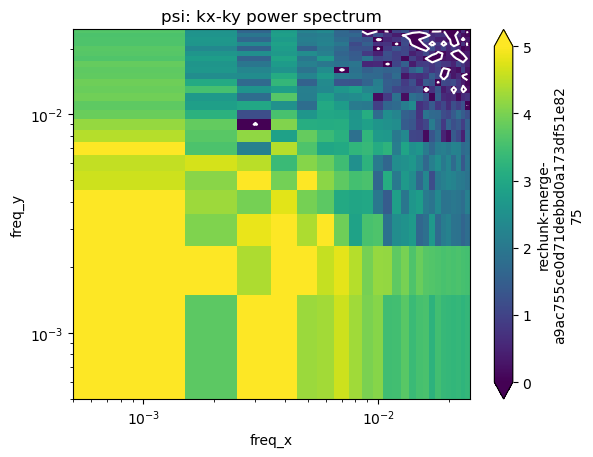

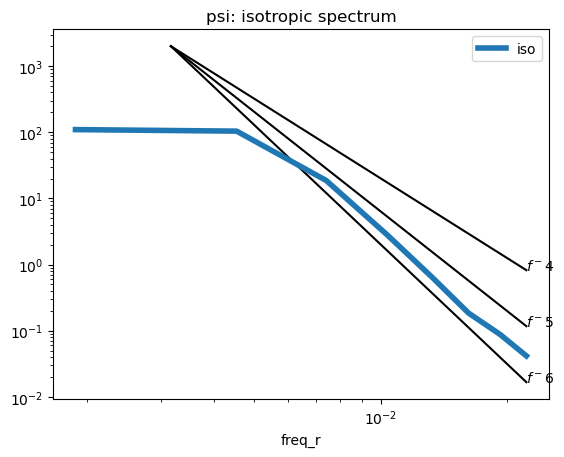

In [19]:
st.plot_spectra(_ds, "psi", yref=2e3, vmin=0, vmax=5, slopes=[-4,-5,-6])

### temporal spectra

/Users/aponte/.miniconda3/envs/nwa/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


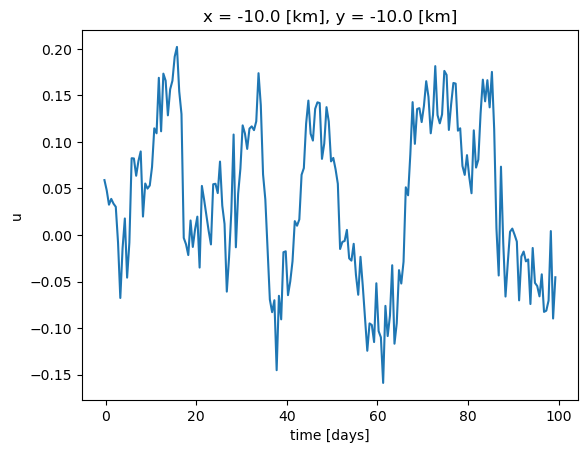

In [20]:
_ds = ds.isel(x=0, y=0).compute()
_ds.u.plot()

E = xrft.power_spectrum(_ds["u"], dim=['time'], detrend='linear', window=True)

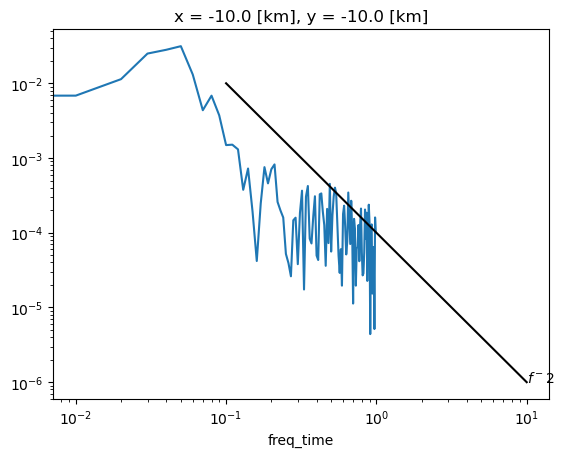

In [21]:
fig, ax = plt.subplots(1,1)
E.plot()
ax.set_xscale("log")
ax.set_yscale("log")

yref = 1e-2
_f = np.logspace(-1, 1, 10)
for s in [-2]:
    ax.plot(_f, yref * (_f/_f[0])**s, color="k")
    ax.text(_f[-1], yref * (_f[-1]/_f[0])**s, r"$f^{}$".format(int(s)))

## setup parcels

In [22]:
from datetime import timedelta

import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

In [23]:
# assemble Field set
ds = xr.open_zarr(os.path.join(run_dir, "flow.zarr"), decode_times=False)
ds["x"] = ds["x"]*1e3 # rescale in m
ds["y"] = ds["y"]*1e3 # rescale in m
ds = ds.rename(x="lon", y="lat")
ds["time"] = ds["time"]*day # rescale in seconds
ds["time"].attrs.update(units="seconds")

nb = 2
bounds = (float(ds["lon"].values[0])  + nb*dx*1e3,
          float(ds["lon"].values[-1]) - nb*dx*1e3,
          float(ds["lat"].values[0])  + nb*dy*1e3,
          float(ds["lat"].values[-1]) - nb*dy*1e3,
)

fieldset = FieldSet.from_xarray_dataset(
    ds,
    variables=dict(U="u", V="v"),
    dimensions=dict(lon="lon", lat="lat", time="time"),                         
    mesh="flat",
)

In [24]:
# create Particle set
di = 5 # subsampling step of input flow grid for parcel seeding position
_ds = ds.isel(lon=slice(10, -10, di), lat=slice(10, -10, di))
x0 = (_ds.lon   + _ds.lat*0).values.flatten()
y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=x0,  # a vector of release longitudes
    lat=y0,  # a vector of release latitudes
    #time=t0,
)

In [15]:
# these are not working anymore, update 
#print(pset)
#pset.show(field=fieldset.U)

In [25]:
zarr = os.path.join(run_dir, "drifters.zarr")

output_file = pset.ParticleFile(
    name=zarr,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

Tmax = np.floor(float(max(ds["time"]/day)))

# deal with boundaries
fieldset.add_constant('b0', bounds[0])
fieldset.add_constant('b1', bounds[1])
fieldset.add_constant('b2', bounds[2])
fieldset.add_constant('b3', bounds[3])
def StopParticle(particle, fieldset, time):
    # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
    # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
    #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
    if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
        or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
        particle.delete()

pset.execute(
    AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
    #AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=Tmax),  # the total length of the run
    dt=timedelta(minutes=30),  # the timestep of the kernel
    #dt=timedelta(minutes=30),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in data/3D_matern52_iso_matern12_pp_r0.0_u0.1/drifters.zarr.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8553600.0/8553600.0 [09:20<00:00, 15254.66it/s]


In [13]:
# necessary for older version of parcels (as old as 2.3.0 at least)
#if production:
#    output_file.export()

## reload and plot

In [26]:
def massage_coords(ds):
    if "lon" in ds:
        ds = ds.rename(lon="x", lat="y")
        ds["x"] = ds["x"]/1e3
        ds["y"] = ds["y"]/1e3
    ds.x.attrs.update(units="km", standard_name="x")
    ds.y.attrs.update(units="km", standard_name="y")
    if "t" in ds:
        ds.t.attrs.update(units="days")
    elif "time" in ds:
        ds.time.attrs.update(units="days")
    return ds

In [27]:
# parcels dataset
ds = xr.open_zarr(os.path.join(run_dir, "drifters.zarr"))
#ds = ds.drop("trajectory").rename_dims(dict(traj="trajectory")) # tmp
ds = ds.chunk(dict(trajectory=100, obs=-1))
ds = ds.assign_coords(t=ds["time"]/pd.Timedelta("1D"))
ds = massage_coords(ds)
ds = ds.persist()

# flow dataset
dsf = xr.open_zarr(os.path.join(run_dir, "flow.zarr"), decode_times=False)
dsf = massage_coords(dsf)
dsf.u.attrs.update(units="m/s")
dsf.v.attrs.update(units="m/s")
dsf["speed"] = np.sqrt(dsf["u"]**2 + dsf["v"]**2)
#dsf = dsf.persist()

Tmax = np.floor(float(ds["t"].max())) # should be 98 days
print(f"Tmax = {Tmax}")
print(f"Number of drifters = {ds.trajectory.size}") #((1000-10*2*2)/2/5)**2

Tmax = 98.0
Number of drifters = 36


Text(0.5, 1.0, 't=-0.25d - 10 out of 36 drifters')

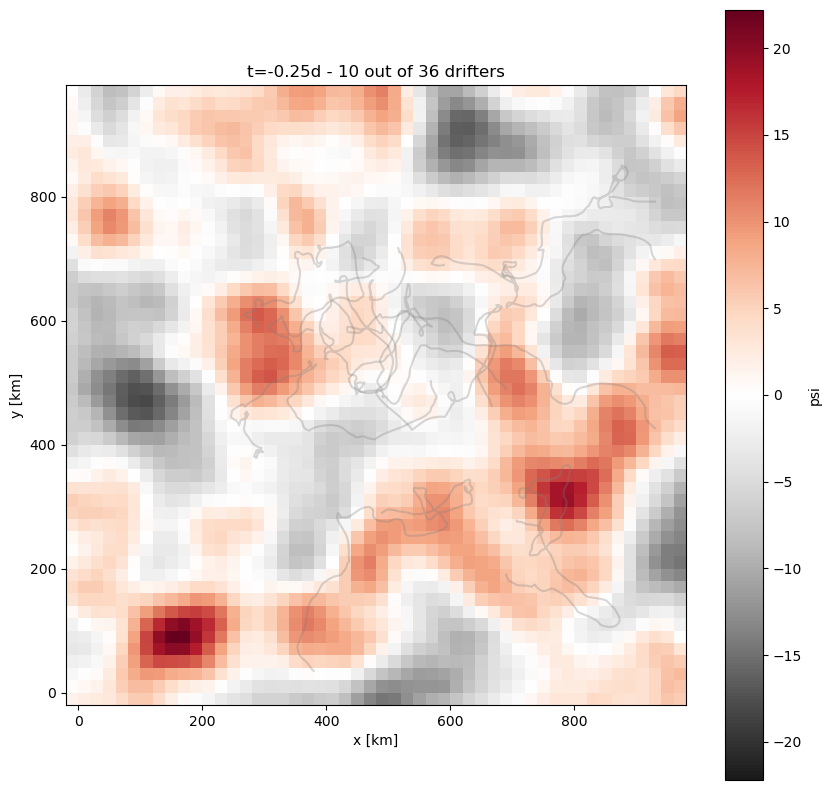

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

v, cmap = "psi", "RdGy_r"
_da = dsf.isel(time=0)[v]
_da.plot(ax=ax, x="x", y="y", cmap=cmap)

_dsd = (
    ds
    #.isel(obs=slice(0, 24*10))
    #.sel(trajectory=np.random.choice(ds.trajectory.values, 500, replace=False))
    .sel(trajectory=np.random.choice(ds.trajectory.values, 10, replace=False)) # dev
)
for tr in _dsd.trajectory:
    _ds = _dsd.sel(trajectory=tr.values)
    ax.plot(_ds.x, _ds.y, color="0.5", alpha=.3)

ax.set_aspect("equal")
ax.set_title(f"t={float(_da.time):.2f}d - {_dsd.trajectory.size} out of {ds.trajectory.size} drifters")

## massage and store trajectories

In [47]:
# trajectory reaching the end of the simulation
def select_add_velocities(ds):
    maxt = ds.t.max("obs").compute()
    n0 = ds.trajectory.size
    #ds = ds.where( ~np.isnan(maxt), drop=True)
    ds = ds.where( maxt>=Tmax , drop=True)
    ns = ds.trajectory.size
    print(f"{ns/n0*100:.1f}% of trajectories survived")
    #
    dt = ds.t.differentiate("obs")*day
    ds["u"] = ds.x.differentiate("obs")/dt*1e3 # x are in km
    ds["v"] = ds.y.differentiate("obs")/dt*1e3 # y are in km
    #
    t = ds.t
    #ds = ds.drop(["t", "time"])
    ds = ds.drop(["time"])
    ds["obs"] = ds.t.isel(trajectory=0)
    ds = ds.drop("t").rename(obs="time")

    return ds

ds_full = select_add_velocities(ds)

# randomly select 20 trajectories
narrow_selection = np.random.choice(ds_full.trajectory.values, 20, replace=False)
dsn = ds_full.sel(trajectory=narrow_selection)

69.4% of trajectories survived


/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_46373/894020318.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(["time"])
/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_46373/894020318.py:18: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop("t").rename(obs="time")


Text(0.5, 1.0, 'drifters not reaching boundaries')

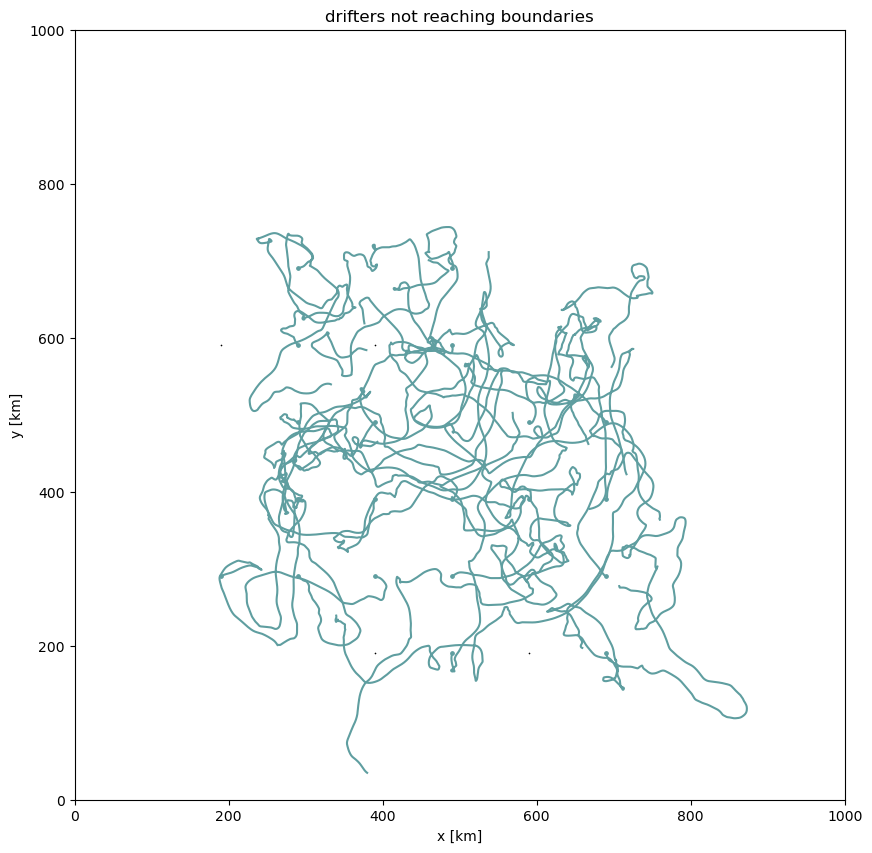

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ds_full.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="k", s=5)
dsn.isel(time=[0]).plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
#dsn.plot.scatter(ax=ax, x="x", y="y", c="cadetblue", s=20)
ax.plot(dsn.x.T, dsn.y.T, color="cadetblue")

ax.set_aspect("equal")
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
ax.set_title("drifters not reaching boundaries")

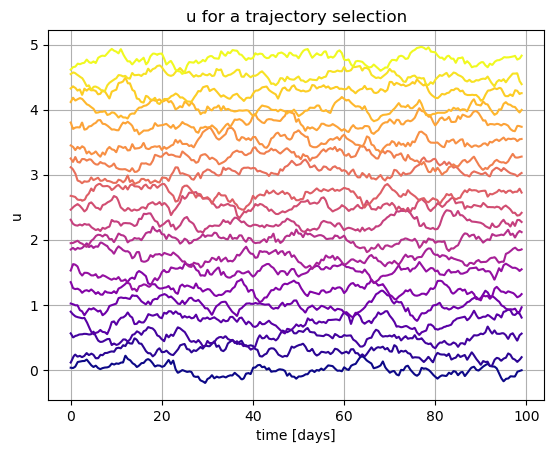

In [50]:
fig, ax = plt.subplots(1,1)
p = plt.get_cmap('plasma')
n = dsn.trajectory.size
for i, t in enumerate(dsn.trajectory):
    (dsn.sel(trajectory=int(t)).u+i/4).plot(ax=ax, x="time", color=p(i/(n-1)))
ax.set_title("u for a trajectory selection")
ax.grid()

In [51]:
# add attributes
dsn.attrs.update(**params)
dsn = dsn.drop("z")

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_46373/4079218472.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dsn = dsn.drop("z")


In [53]:
if production:
    dsn.to_netcdf(os.path.join(run_dir, "drifters_selection.nc"), mode="w")

In [54]:
dsf_sel = (dsf
    .sel(x=dsn.isel(time=0, drop=True).x, y=dsn.isel(time=0, drop=True).y, method="nearest")
    .drop_vars("speed")
    .compute()
)
dsf_sel.attrs.update(**params)

In [55]:
if production:
    dsf_sel.to_netcdf(os.path.join(run_dir, "flow_selection.nc"), mode="w")

---
## drifter turbophoresis

In [7]:
dsE = xr.open_zarr(os.path.join(run_dir, "flow.zarr"), decode_times=False)
dsL = st.open_drifter_file(run_dir)

In [24]:
speed_E = np.sqrt(dsE["u"]**2+dsE["v"]**2).mean(["x", "y"]).compute()
speed_L = np.sqrt(dsL["u"]**2+dsL["v"]**2).mean("trajectory").compute()

In [ ]:
speed_E.plot()
speed_L.plot()

In [29]:
speed_Ei = speed_E.interp(time=speed_L.time) 

In [ ]:
fig, ax = plt.subplots(1,1)
(speed_Ei - speed_L).plot(ax=ax)
ax.axhline((speed_Ei - speed_L).mean(), color="0.5", ls="--")
ax.grid()
ax.set_title("$E_{\mathrm{moorings}} - E_{\mathrm{drifters}}$")
ax.set_xlabel("time [days]")
ax.set_ylabel("[m/s]")

In [38]:
# mean difference and normalized difference (in percents)
float((speed_Ei - speed_L).mean()), float((speed_Ei - speed_L).mean()/speed_Ei.mean())*1e2

(0.002217815441388478, 1.7572699320460972)

In [41]:
# extrapolated to gamma in reference config
1.77/100*0.077

0.0013629

---
## movies

In [18]:
dsE = xr.open_zarr(os.path.join(run_dir, "flow.zarr"), decode_times=False)

flow_scale = None
flow_scale = 0.02 # alpha = 0.02 x 0.4 = 0.008
flow_scale = 3.94 # alpha = 3.94 x 0.4 = 1.6
dsL = st.open_drifter_file(run_dir, flow_scale=flow_scale, filter=False)

# add initial positions and transform in indexes: dangerous (assumes square grid)
dsLg = (dsL
    .assign_coords(x0 = dsL.x.isel(time=0, drop=True), y0 = dsL.y.isel(time=0, drop=True))
    .set_index({"trajectory": ["x0", "y0"]})
    .unstack()
)

Tmax = 98.00 days
6.7% of trajectories survived


In [19]:
#fig_dir = "/Users/aponte/tmp/figs"
fig_dir = "/home1/scratch/aponte/figs" # datarmor

def plot_snapshot(t, i, v, v_label=None, flow_scale=None, vkwargs={}, trail=24, sel=None, dry=False):

    t = float(dsL.time.sel(time=t).min())
    
    #fig, ax = plt.subplots(1,1, figsize=(9,8))
    fig, ax = plt.subplots(1,1, figsize=(6,5))

    # color field
    if v_label is None:
        v_label = v
    _da = dsE[v].rename(v_label).interp(time=t)
    if flow_scale is not None:
        _da = _da * flow_scale
    dkwargs = dict(x="x", y="y", extend="neither")
    dkwargs.update(**vkwargs)
    if "levels" in dkwargs:
        _da.plot.contourf(ax=ax, **dkwargs)
    else:
        _da.plot(ax=ax, **dkwargs)

    # trajectories
    #_ds = ds.isel(trajectory=slice(0,None,10))
    #_ds = ds.sel(obs=slice(o-trail, t))
    #_ds.plot.scatter(ax=ax, x="x", y="y", c="0.5", s=0.1)
    #for tr in ds.trajectory[::10]:
    for x, y in product(dsLg.x0[::5], dsLg.y0[::5]):
        _tr = dsLg.sel(x0=x, y0=y)
        _tr = _tr.where( (_tr.time<=t) & (_tr.time>=t-trail), drop=True)
        ax.plot(_tr.x, _tr.y, color="k", alpha=.5, lw=1.5)
        if _tr.x.size>0:
            ax.scatter(_tr.x[-1], _tr.y[-1], c="k", marker="o", s=2.)
    if sel is not None:
        for x, y, c in zip(sel["x"], sel["y"], sel["c"]):
            _tr = dsLg.sel(x0=x, y0=y) #, obs=slice(o-trail, o))
            _tr = _tr.where( (_tr.t<=t) & (_tr.t>=t-trail), drop=True)
            if _tr.x.size>0:
                ax.plot(_tr.x, _tr.y, color=c, alpha=1., lw=4)
                ax.scatter(_tr.x[-1], _tr.y[-1], c=c, marker="*", s=200., edgecolors="k", zorder=20)
    
    ax.set_aspect("equal")
    ax.set_title(f"t={t:.2f} d")

    if not dry:
        fig_path = os.path.join(fig_dir, f"fig_{i:04}.png")
        fig.savefig(fig_path, dpi=150)
        # other relevant options: facecolor='w', bbox_inches = 'tight'
        plt.close(fig)
    

In [20]:
#v, cmap = "psi", "RdBu_r"
v, cmap = "psi", "RdYlBu_r"
#vkwargs = dict(cmap=cmap, levels=np.arange(-50,52,2), cbar_kwargs={'shrink':0.8})
vmax = η*3.
_scale = flow_scale
if flow_scale is None:
    _scale = 1.
vkwargs = dict(cmap=cmap, vmin=-vmax*_scale, vmax=vmax*_scale, cbar_kwargs={'shrink':1.})

# selected trajectories
#tr = dsn.trajectory[:3]
#_ds = dsn.isel(time=0).sel(trajectory=tr)
#sel = dict(tr=tr, x=_ds.x, y=_ds.y, c=["cadetblue", "blueviolet", "peru"])
sel = None

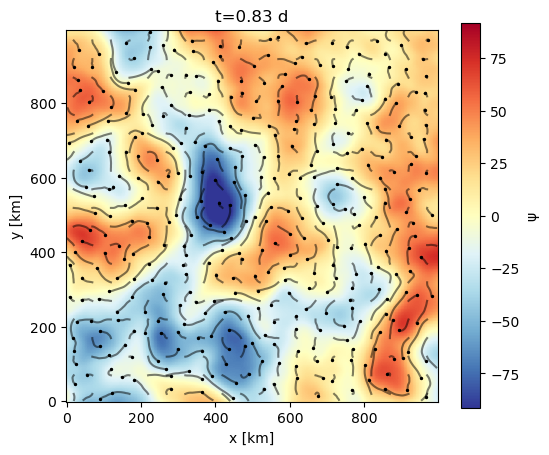

In [21]:
t, i = dsL.time[20].values, 0
plot_snapshot(t, i, v, v_label="ψ", flow_scale=flow_scale, vkwargs=vkwargs, trail=1., sel=sel, dry=True)
#plot_snapshot(t, i, v, v_label="ψ", flow_scale=flow_scale, vkwargs=vkwargs, trail=1., sel=sel)

In [22]:
for i, t in enumerate(tqdm(dsL.time.values[::6])):
    plot_snapshot(t, i, v, v_label="ψ", flow_scale=flow_scale, vkwargs=vkwargs, trail=1., sel=sel)

100%|██████████| 393/393 [40:01<00:00,  6.11s/it] 


To generate movie:

```
ffmpeg -framerate 10 -pattern_type glob -i "*.png" -c:v libx264 -pix_fmt yuv420p movie.mp4
```

In [15]:
fig_dir

'/home1/scratch/aponte/figs'

---

### drifter timeseries, matern12 in time

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,3))

for tr, x, y, c in zip(sel["tr"], sel["x"], sel["y"], sel["c"]):
    da = ds_full.sel(trajectory=tr)["u"]
    da.plot(ax=ax, color=c)
    
ax.grid()
ax.set_title("drifter velocity")
ax.set_xlabel("time [days]")
ax.set_ylabel("[m/s]")

### mooring: matern12 in time

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,3))

_ds = dsf_sel.sel(trajectory=[0,1,2])

for tr, c in zip(_ds.trajectory, sel["c"]):
    da = _ds.sel(trajectory=tr)["u"]
    print(float(da.x), float(da.y), c)
    da.plot(ax=ax, color=c)
    
ax.grid()
ax.set_title("mooring velocity")
ax.set_xlabel("time [days]")
ax.set_ylabel("[m/s]")
